---
format:
  revealjs: 
    slide-number: true
    height: 900
    theme: [blood]
    incremental: true
---

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from sklearn.feature_extraction.text import CountVectorizer
import json
#import marimo as mo

/Users/11nho/Documents/School/604/FinalProject/.direnv/python-3.12.10/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_json(file):
    with open(file) as f:
        data = json.load(f)
        return data

speeches = pd.DataFrame(load_json("speeches.json"))
speeches.head()

,doc_name,date,transcript,president,title
0,january-22-1807-special-message-congress-burr-...,1807-01-22,TO THE SENATE AND HOUSE OF REPRESENTATIVES OF ...,Thomas Jefferson,"January 22, 1807: Special Message to Congress ..."
1,may-25-1813-message-special-congressional-sess...,1813-05-25,Fellow-Citizens of the Senate and of the House...,James Madison,"May 25, 1813: Message on the Special Congressi..."
2,april-2-1917-address-congress-requesting-decla...,1917-04-02,I have called the Congress into extraordinary ...,Woodrow Wilson,"April 2, 1917: Address to Congress Requesting ..."
3,april-10-1975-address-us-foreign-policy,1975-04-10,"Mr. Speaker, Mr. President, distinguished gues...",Gerald Ford,"April 10, 1975: Address on U.S. Foreign Policy"
4,july-6-1848-message-regarding-treaty-guadalupe...,1848-07-06,To the House of Representatives of the United ...,James K. Polk,"July 6, 1848: Message Regarding the Treaty of ..."


In [3]:
speeches.drop(columns=['doc_name'], inplace=True)
speeches

,date,transcript,president,title
0,1807-01-22,TO THE SENATE AND HOUSE OF REPRESENTATIVES OF ...,Thomas Jefferson,"January 22, 1807: Special Message to Congress ..."
1,1813-05-25,Fellow-Citizens of the Senate and of the House...,James Madison,"May 25, 1813: Message on the Special Congressi..."
2,1917-04-02,I have called the Congress into extraordinary ...,Woodrow Wilson,"April 2, 1917: Address to Congress Requesting ..."
3,1975-04-10,"Mr. Speaker, Mr. President, distinguished gues...",Gerald Ford,"April 10, 1975: Address on U.S. Foreign Policy"
4,1848-07-06,To the House of Representatives of the United ...,James K. Polk,"July 6, 1848: Message Regarding the Treaty of ..."
...,...,...,...,...
1056,1917-04-06,Whereas the Congress of the United States in t...,Woodrow Wilson,"April 6, 1917: Proclamation 1364"
1057,1965-07-13,"THE PRESIDENT. Good afternoon, ladies and gent...",Lyndon B. Johnson,"July 13, 1965: Press Conference in the East Room"
1058,1872-12-02,To the Senate and House of Representatives: In...,Ulysses S. Grant,"December 2, 1872: Fourth Annual Message"
1059,1867-07-19,To the House of Representatives of the United ...,Andrew Johnson,"July 19, 1867: Message Regarding Reconstructio..."


In [4]:
print(speeches['president'].unique())

['Thomas Jefferson' 'James Madison' 'Woodrow Wilson' 'Gerald Ford'
 'James K. Polk' 'George W. Bush' 'Lyndon B. Johnson'
 'Franklin D. Roosevelt' 'James Monroe' 'John F. Kennedy'
 'Chester A. Arthur' 'Donald Trump' 'Harry S. Truman' 'George Washington'
 'Ronald Reagan' 'John Tyler' 'Bill Clinton' 'Grover Cleveland'
 'Richard M. Nixon' 'Calvin Coolidge' 'Andrew Jackson' 'Jimmy Carter'
 'Abraham Lincoln' 'Franklin Pierce' 'Joe Biden' 'Barack Obama'
 'Rutherford B. Hayes' 'Benjamin Harrison' 'Herbert Hoover'
 'George H. W. Bush' 'Theodore Roosevelt' 'Ulysses S. Grant'
 'Warren G. Harding' 'Andrew Johnson' 'Martin Van Buren'
 'James A. Garfield' 'James Buchanan' 'William McKinley' 'William Taft'
 'Dwight D. Eisenhower' 'John Quincy Adams' 'John Adams' 'Zachary Taylor'
 'William Harrison' 'Millard Fillmore']


In [5]:
presidents = pd.read_csv("presidents.csv")
presidents

,President Name,Years In Office,Number,Party,Average Approval Rating Percentage
0,Harry S. Truman,1945-1953,33rd,Democratic,45.4
1,Dwight D. Eisenhower,1953-1961,34th,Republican,65.0
2,John F. Kennedy,1961-1963,35th,Democratic,70.1
3,Lyndon B. Johnson,1963-1969,36th,Democratic,55.1
4,Richard M. Nixon,1969-1974,37th,Republican,49.0
5,Gerald Ford,1974-1977,38th,Republican,47.2
6,Jimmy Carter,1977-1981,39th,Democratic,45.5
7,Ronald Reagan,1981-1989,40th,Republican,52.8
8,George H. W. Bush,1989-1993,41st,Republican,60.9
9,Bill Clinton,1993-2001,42nd,Democratic,55.1


In [6]:
pres_names = presidents['President Name'].str.replace(' ', '', regex=True)
speeches_clean = speeches[speeches['president'].str.replace(' ', '', regex=True).isin(pres_names)]
speeches_clean = speeches_clean.sort_values('date').reset_index(drop=True)
speeches_clean = speeches_clean[['date', 'president','title','transcript']]
speeches_clean['doc_id'] = speeches_clean.index
cols = ['doc_id'] + [col for col in speeches_clean.columns if col != 'doc_id']
speeches_clean = speeches_clean[cols]
speeches_clean.set_index('doc_id', inplace=True)
speeches_clean

,date,president,title,transcript
doc_id,,,,
0,1945-04-16,Harry S. Truman,"April 16, 1945: First Speech to Congress","Mr. Speaker, Mr. President, Members of the Con..."
1,1945-05-08,Harry S. Truman,"May 8, 1945: Announcing the Surrender of Germany",This is a solemn but a glorious hour. I only w...
2,1945-08-06,Harry S. Truman,"August 6, 1945: Statement by the President Ann...",Sixteen hours ago an American airplane dropped...
3,1945-08-09,Harry S. Truman,"August 9, 1945: Radio Report to the American P...",My fellow Americans:\n\nI have just returned f...
4,1945-09-01,Harry S. Truman,"September 1, 1945: Announcing the Surrender of...",The thoughts and hopes of all America—indeed o...
...,...,...,...,...
492,2024-07-24T20:00:00-04:00,Joe Biden,"July 24, 2024: Statement to the American People","<p class=""p1""><span class=""s1"">THE PRESIDENT: ..."
493,2024-09-24T10:12:00-04:00,Joe Biden,"September 24, 2024: Address before the 79th Un...","<p class=""p1""><span class=""s1"">THE PRESIDENT: ..."
494,2025-01-15T20:00:00-05:00,Joe Biden,"January 15, 2025: Farewell Address","THE PRESIDENT: My fellow Americans, I am speak..."


In [7]:
print(speeches_clean['president'].unique())

['Harry S. Truman' 'Richard M. Nixon' 'Dwight D. Eisenhower'
 'John F. Kennedy' 'Lyndon B. Johnson' 'Ronald Reagan' 'Gerald Ford'
 'Jimmy Carter' 'George H. W. Bush' 'Bill Clinton' 'George W. Bush'
 'Barack Obama' 'Donald Trump' 'Joe Biden']


In [8]:
speeches_clean['tokenized_text'] = speeches_clean['transcript'].apply(word_tokenize)

In [9]:
import re
def clean_text(text):
    # Remove special characters and numbers, but keep sentence-ending punctuation and apostrophes
    text = re.sub(r'[^A-Za-z\s.?!,:\']', '', text) 
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Normalize whitespace (remove leading/trailing and extra spaces within)
    text = ' '.join(text.split())

    return text

def preprocess_text(text):
    text = clean_text(text)
    # Tokenize text
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]

    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    return lemmatized_tokens

def token_to_text(tokens):
    preprocessed_text = " ".join(tokens)

    return preprocessed_text

speeches_clean['lem_tokenized_text'] = speeches_clean['transcript'].apply(preprocess_text)
speeches['transcript_clean'] = speeches['transcript'].apply(clean_text)
speeches_clean['transcript_clean'] = speeches_clean['transcript'].apply(clean_text)

In [10]:
vectorizer_model = CountVectorizer(stop_words="english")
representation_model = KeyBERTInspired(random_state=66)
topic_model = BERTopic(vectorizer_model=vectorizer_model, representation_model=representation_model, min_topic_size=5)
topics, probs = topic_model.fit_transform(speeches['transcript_clean'].to_list())
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,375,-1_congress_constitution_president_federal,"[congress, constitution, president, federal, g...",[To the Senate and House of Representatives: T...
1,0,55,0_president_congress_economy_americas,"[president, congress, economy, americas, refor...","[Mr. Speaker, Mr. Vice President, Members of C..."
2,1,53,1_congress_treaty_constitution_citizens,"[congress, treaty, constitution, citizens, gov...",[Fellow citizens of the Senate and House of Re...
3,2,35,2_constitution_congress_citizens_duties,"[constitution, congress, citizens, duties, gov...",[To the Senate and House of Representatives of...
4,3,34,3_treasury_banking_bank_banks,"[treasury, banking, bank, banks, currency, fed...",[To the Senate and House of Representatives: F...
5,4,32,4_proclamation_unconstitutional_constitution_s...,"[proclamation, unconstitutional, constitution,...",[By the President of the United States of Amer...
6,5,29,5_vietnam_vietnamese_war_hanoi,"[vietnam, vietnamese, war, hanoi, peace, presi...",[THE PRESIDENT. My fellow Americans: Not long ...
7,6,24,6_treaties_panama_treaty_congress,"[treaties, panama, treaty, congress, canal, se...",[To the Congress of the United States: At the ...
8,7,24,7_constitution_provisions_treaty_legislature,"[constitution, provisions, treaty, legislature...",[Circumstances have occurred to disturb the co...
9,8,23,8_afghanistan_taliban_afghan_afghans,"[afghanistan, taliban, afghan, afghans, qaeda,...","[THE PRESIDENT: Good afternoon. Earlier today,..."


In [11]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()
all_sentences = []

for doc_id, row in speeches_clean.iterrows():
    sentences = sent_tokenize(row['transcript_clean'])
    for idx, sentence in enumerate(sentences):
        score = sia.polarity_scores(sentence)['compound']
        all_sentences.append({
            'doc_id': doc_id,
            'sentence_index': idx,
            'sentence_text': sentence,
            'sentiment_score': score
        })


sentence_sentiment = pd.DataFrame(all_sentences)
sentence_sentiment.head()

,doc_id,sentence_index,sentence_text,sentiment_score
0,0,0,"Mr. Speaker, Mr. President, Members of the Con...",0.7096
1,0,1,"Only yesterday, we laid to rest the mortal rem...",0.5106
2,0,2,"At a time like this, words are inadequate.",-0.0516
3,0,3,The most eloquent tribute would be a reverent ...,0.0000
4,0,4,"Yet, in this decisive hour, when world events ...",-0.2441


In [12]:
import textstat

def lexical_diversity(text):
    tokens = word_tokenize(text.lower())
    unique_tokens = set(tokens)
    return len(unique_tokens) / len(tokens) if len(tokens) > 0 else 0


def get_readability_metrics(text):
    return {
        'flesch_reading_ease': textstat.flesch_reading_ease(text),
        'flesch_kincaid_grade': textstat.flesch_kincaid_grade(text),
        'smog_index': textstat.smog_index(text),
        'coleman_liau_index': textstat.coleman_liau_index(text),
        'automated_readability_index': textstat.automated_readability_index(text),
        'dale_chall_score': textstat.dale_chall_readability_score(text),
        'difficult_words': textstat.difficult_words(text),
        'readability_consensus': textstat.text_standard(text, float_output = True)
    }

def add_speech_metrics(row):
    text = row['transcript_clean']
    metrics = get_readability_metrics(text)
    metrics['lexical_diversity'] = lexical_diversity(text)
    return pd.Series(metrics)

df_metrics = speeches_clean.apply(add_speech_metrics, axis=1)
df_overall = pd.concat([speeches_clean, df_metrics], axis=1)

df_overall

,date,president,title,transcript,tokenized_text,lem_tokenized_text,transcript_clean,flesch_reading_ease,flesch_kincaid_grade,smog_index,coleman_liau_index,automated_readability_index,dale_chall_score,difficult_words,readability_consensus,lexical_diversity
doc_id,,,,,,,,,,,,,,,,
0,1945-04-16,Harry S. Truman,"April 16, 1945: First Speech to Congress","Mr. Speaker, Mr. President, Members of the Con...","[Mr., Speaker, ,, Mr., President, ,, Members, ...","[Mr., Speaker, ,, Mr., President, ,, Members, ...","Mr. Speaker, Mr. President, Members of the Con...",55.03,9.6,11.8,9.57,9.2,7.41,299.0,10.0,0.328358
1,1945-05-08,Harry S. Truman,"May 8, 1945: Announcing the Surrender of Germany",This is a solemn but a glorious hour. I only w...,"[This, is, a, solemn, but, a, glorious, hour, ...","[solemn, glorious, hour, ., wish, Franklin, D....",This is a solemn but a glorious hour. I only w...,59.13,10.1,11.8,8.12,10.0,7.71,114.0,10.0,0.403372
2,1945-08-06,Harry S. Truman,"August 6, 1945: Statement by the President Ann...",Sixteen hours ago an American airplane dropped...,"[Sixteen, hours, ago, an, American, airplane, ...","[Sixteen, hour, ago, American, airplane, dropp...",Sixteen hours ago an American airplane dropped...,49.96,11.6,13.5,10.15,11.8,8.04,207.0,12.0,0.382258
3,1945-08-09,Harry S. Truman,"August 9, 1945: Radio Report to the American P...",My fellow Americans:\n\nI have just returned f...,"[My, fellow, Americans, :, I, have, just, retu...","[fellow, Americans, :, returned, Berlin, ,, ci...",My fellow Americans: I have just returned from...,52.49,10.6,13.0,9.98,10.5,7.08,561.0,11.0,0.241114
4,1945-09-01,Harry S. Truman,"September 1, 1945: Announcing the Surrender of...",The thoughts and hopes of all America—indeed o...,"[The, thoughts, and, hopes, of, all, America—i...","[thought, hope, Americaindeed, civilized, worl...",The thoughts and hopes of all Americaindeed of...,56.89,11.0,12.5,8.71,11.2,7.54,166.0,11.0,0.340221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,2024-07-24T20:00:00-04:00,Joe Biden,"July 24, 2024: Statement to the American People","<p class=""p1""><span class=""s1"">THE PRESIDENT: ...","[<, p, class=, '', p1, '', >, <, span, class=,...","[p, classpspan, classsTHE, PRESIDENT, :, fello...",p classpspan classsTHE PRESIDENT: My fellow Am...,56.66,9.0,12.2,13.51,12.0,7.08,225.0,9.0,0.329079
493,2024-09-24T10:12:00-04:00,Joe Biden,"September 24, 2024: Address before the 79th Un...","<p class=""p1""><span class=""s1"">THE PRESIDENT: ...","[<, p, class=, '', p1, '', >, <, span, class=,...","[p, classpspan, classsTHE, PRESIDENT, :, fello...",p classpspan classsTHE PRESIDENT: My fellow le...,56.05,9.2,11.4,10.84,10.1,7.32,509.0,10.0,0.293286
494,2025-01-15T20:00:00-05:00,Joe Biden,"January 15, 2025: Farewell Address","THE PRESIDENT: My fellow Americans, I am speak...","[THE, PRESIDENT, :, My, fellow, Americans, ,, ...","[PRESIDENT, :, fellow, Americans, ,, speaking,...","THE PRESIDENT: My fellow Americans, I am speak...",54.12,10.0,11.7,8.87,9.2,7.40,361.0,10.0,0.306130


In [13]:
df_polarity = sentence_sentiment[['doc_id','sentiment_score']]
df_polarity_avg = df_polarity.groupby('doc_id')['sentiment_score'].mean().reset_index()

In [14]:
df_polarity_avg

,doc_id,sentiment_score
0,0,0.213680
1,1,0.163097
2,2,-0.028956
3,3,0.113427
4,4,0.152624
...,...,...
492,492,0.284615
493,493,0.078983
494,494,0.243311
495,495,0.235205


In [15]:
pres_info = presidents
pres_info.rename(columns={'President Name': 'president'}, inplace=True)
#pres_info['President Name'].str.replace(' ', '', regex=True)

In [16]:
metrics = [
    'president',
    'flesch_reading_ease',
    'flesch_kincaid_grade', 
    'smog_index', 
    'coleman_liau_index',
    'automated_readability_index', 
    'dale_chall_score', 
    'difficult_words',
    'readability_consensus', 
    'lexical_diversity'   
]
df_subset = df_overall[metrics]
df_subset = df_subset.merge(df_polarity_avg, on='doc_id', how='left')
pres_speech_means = df_subset.groupby('president').mean().reset_index()
pres_speech_means = pres_speech_means.merge(pres_info, on='president', how='left')
pres_speech_means = pres_speech_means.drop(columns=['Number','Years In Office'])

In [17]:
pres_speech_means.columns

Index(['president', 'doc_id', 'flesch_reading_ease', 'flesch_kincaid_grade',
       'smog_index', 'coleman_liau_index', 'automated_readability_index',
       'dale_chall_score', 'difficult_words', 'readability_consensus',
       'lexical_diversity', 'sentiment_score', 'Party',
       'Average Approval Rating Percentage'],
      dtype='object')

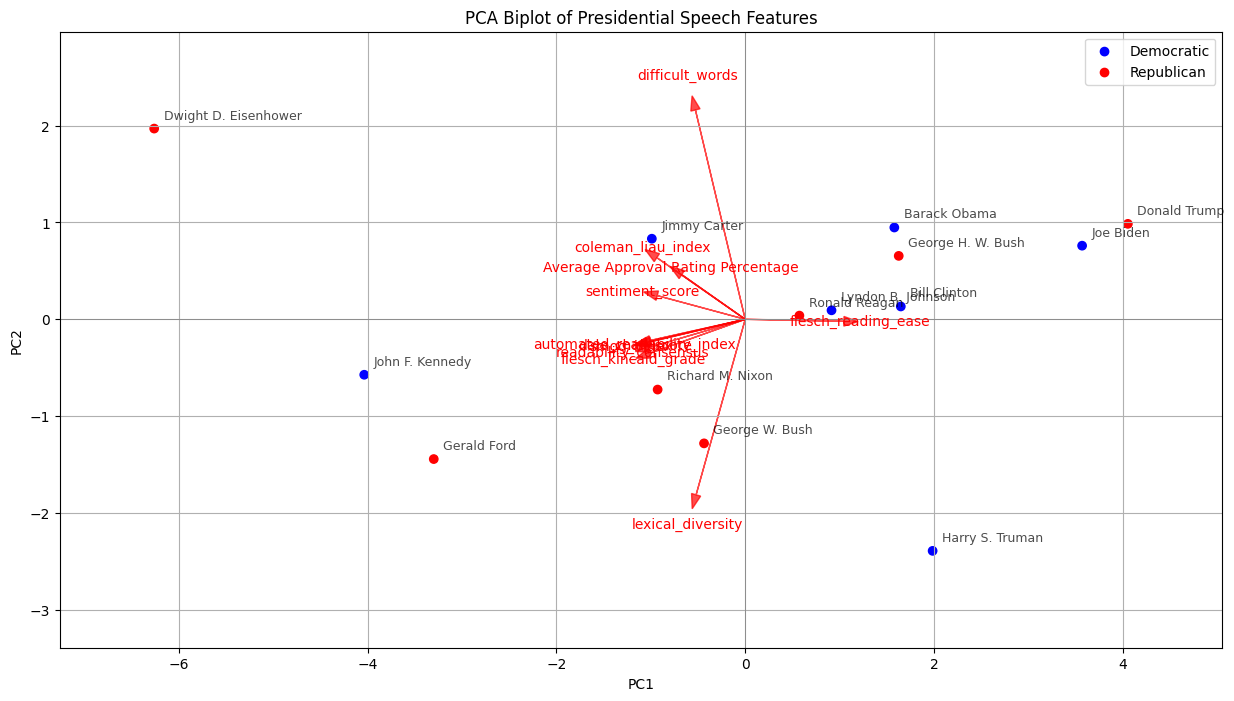

In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

labels = ['president','Party']
drops = labels + ['doc_id']
identifiers = pres_speech_means[labels].copy()
X = pres_speech_means.drop(drops, axis=1)
reduced_data = X.copy()
X_scaled = StandardScaler().fit_transform(X)

# PCA
pca = PCA(n_components=2, random_state=66)
principalComponents = pca.fit_transform(X_scaled)
loadings = pca.components_.T  # Each row corresponds to a feature

# Build PCA scores DataFrame
df_pca = pd.DataFrame(principalComponents, columns=['PC1', 'PC2'])
df_pca = pd.concat([identifiers.reset_index(drop=True), df_pca], axis=1)

# Plot
fig, ax = plt.subplots(figsize=(15, 8))
fig.patch.set_facecolor('white')

# Scatter points (presidents)
for party in df_pca['Party'].unique():
    if party == "Republican":
        color = ['red']
    else:
        color = ['blue']
    subset = df_pca[df_pca['Party'] == party]
    color = color * len(subset)
    ax.scatter(subset['PC1'], subset['PC2'], label=party, c=color)

# Draw variable loadings as arrows
for i, feature in enumerate(reduced_data):
    ax.arrow(0, 0, loadings[i, 0]*3, loadings[i, 1]*3,
             color='red', alpha=0.7, head_width=0.1)
    ax.text(loadings[i, 0]*3.5, loadings[i, 1]*3.5, feature, color='red', ha='center', va='center')

# Add text labels to each point (president)
for _, row_num in df_pca.iterrows():
    ax.text(row_num['PC1'] + 0.1, row_num['PC2'] + 0.1, row_num['president'],
            fontsize=9, alpha=0.7, color='black')

#ax.spines['top'].set_color('black')
#ax.spines['right'].set_color('black')
#ax.spines['left'].set_color('black')
#ax.spines['bottom'].set_color('black')

ax.set_xlabel('PC1',)
ax.set_ylabel('PC2')
ax.set_xlim(df_pca['PC1'].min() - 1, df_pca['PC1'].max() + 1)
ax.set_ylim(df_pca['PC2'].min() - 1, df_pca['PC2'].max() + 1)
ax.axhline(0, color='gray', linewidth=0.5)
ax.axvline(0, color='gray', linewidth=0.5)
ax.set_title('PCA Biplot of Presidential Speech Features')
ax.legend()
#ax.set_facecolor('white')
plt.grid(True)
plt.show()

# Plot Ideas
- Topics changes over time (lines)
- Sentiment by President
- Topic by president
- Speech Complexity, readability, lexicon, etc. by President / Time